In [175]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import statistics

import data_cleaning

# Summary

This is an analysis originated from a bounty from [DiamondDAO](https://docs.diamonddao.xyz/welcome/values) that aims to analyze the data coming form ETH Denver attendees and their pathway in crypto after the event.

**Main objective:** 
- To determine the profile of inviduals attending the event.
- To understand the impacts of the event in the ecosystem. 

# Data loading / cleaning

## Loading..

In [176]:
#POAP data
poap = data_cleaning.get_cleaned_poap_data()

#DAOHaus data
dh_members, dh_proposals, dh_votes = data_cleaning.get_daohaus_cleaned_data()

#Snapshot data
snap_proposals, snap_votes, snap_creation = data_cleaning.get_snapshot_cleaned_data()

#Token balance data
spork, bufficorns = data_cleaning.get_token_holder_cleaned_data()

## Making adjustments and merges..

#### Creating identifier columns

In [177]:
# ETH Denver check
poap['is_ETHDenver_event'] = False
poap.loc[(poap.event_name.str.contains('ethdenver', case=False)) 
         | (poap.event_name.str.contains('eth denver', case=False)), 'is_ETHDenver_event'] = True


# Checking if it's an ethereum event (will not be 100% right here, but checking output I would assume this is good enough)
poap['is_ethereum_related_event'] = False
poap.loc[(poap.event_name.str.contains('eth',case=False)) |
              (poap.event_name.str.contains('ethereum', case=False)), 'is_ethereum_related_event'] = True

#marking all ETHDenver POAP holder
eth_denver_poap_holders = poap.loc[poap.is_ETHDenver_event==True, 'owner_id_checksum'].unique()
poap['has_ETH_Denver_POAP'] = False
poap.loc[poap.owner_id_checksum.isin(eth_denver_poap_holders), 'has_ETH_Denver_POAP'] = True

#### Merging SPORK holders data on POAP data

In [178]:
spork = spork.rename(columns={'holder_address': 'spork_holder_address', 
                              'balance':'spork_balance', 
                              'normalized_balance': 'spork_normalized_balance'})

poap = poap.merge(spork, left_on='owner_id_checksum', right_on='spork_holder_address', how='left')

poap['is_spork_holder'] = False
poap.loc[poap.spork_holder_address.notnull(), 'is_spork_holder'] = True

sphold = poap.groupby(['has_ETH_Denver_POAP', 'is_spork_holder']).agg(attendee_count=('owner_id', 'nunique'))
sphold['%'] = (sphold['attendee_count'] / sphold.groupby(level=0).transform('sum')['attendee_count']) * 100

#marking ETH Denver attendees after adding SPORK data
poap['is_ETH_Denver_participant'] = False
poap.loc[(poap.has_ETH_Denver_POAP==True) | (poap.is_spork_holder==True), 'is_ETH_Denver_participant'] = True

sphold

attendee_count          %
has_ETH_Denver_POAP is_spork_holder                           
False               False                    682422  99.858353
                    True                        968   0.141647
True                False                       746  71.730769
                    True                        294  28.269231

**Comment**: There is a considerable amount of spork holder that do not have have ETH Denver POAP.

#### Creating new dataset to have all POAP holder, SPORK holders and Bufficorn minters

In [179]:
ethd = poap.loc[poap.has_ETH_Denver_POAP==True, ['owner_id_checksum', 'has_ETH_Denver_POAP']].copy().drop_duplicates('owner_id_checksum')
ethd = ethd.rename(columns={'owner_id_checksum': 'address'})

spork_v2 = spork.rename(columns={'spork_holder_address': 'address'})
bufficorns_v2 = bufficorns.rename(columns={'bufficorn_minter_address': 'address'})
bufficorns_v2 = bufficorns_v2.drop_duplicates('address')

ethd = ethd.merge(spork_v2, on='address', how='outer')
ethd = ethd.merge(bufficorns_v2, on='address', how='outer')

In [180]:
ethd['profile_type'] = ''

ethd.loc[(ethd.has_ETH_Denver_POAP.notnull()) &
        (ethd.spork_balance.isnull())
         & (ethd.bufficorn_token_id.isnull()), 'profile_type'] = 'poap_holder_only'

ethd.loc[(ethd.has_ETH_Denver_POAP.isnull()) &
        (ethd.spork_balance.notnull())
         & (ethd.bufficorn_token_id.isnull()), 'profile_type'] = 'spork_holder_only'

ethd.loc[(ethd.has_ETH_Denver_POAP.isnull()) &
        (ethd.spork_balance.isnull())
         & (ethd.bufficorn_token_id.notnull()), 'profile_type'] = 'bufficorn_holder_only'

ethd.loc[(ethd.has_ETH_Denver_POAP.notnull()) &
        (ethd.spork_balance.notnull())
         & (ethd.bufficorn_token_id.isnull()), 'profile_type'] = 'poap_and_spork_holder'

ethd.loc[(ethd.has_ETH_Denver_POAP.notnull()) &
        (ethd.spork_balance.isnull())
         & (ethd.bufficorn_token_id.notnull()), 'profile_type'] = 'poap_and_bufficorn_holder'

ethd.loc[(ethd.has_ETH_Denver_POAP.isnull()) &
        (ethd.spork_balance.notnull())
         & (ethd.bufficorn_token_id.notnull()), 'profile_type'] = 'spork_and_bufficorn_holder'

ethd.loc[(ethd.has_ETH_Denver_POAP.notnull()) &
        (ethd.spork_balance.notnull())
         & (ethd.bufficorn_token_id.notnull()), 'profile_type'] = 'poap_spork_and_bufficorn_holder'

ethd.groupby('profile_type').agg(wallet_count=('address', 'nunique'))

,wallet_count
profile_type,
bufficorn_holder_only,797
poap_and_bufficorn_holder,15
poap_and_spork_holder,184
poap_holder_only,731
poap_spork_and_bufficorn_holder,110
spork_and_bufficorn_holder,627
spork_holder_only,1236


#### Support functions

In [181]:
def calculate_multisample_t_test( treatment_values:pd.Series, control_values: pd.Series, n_runs:int=1000, alpha:int=5):
    '''
    Run n t-tests for a big to_split_dataset
    
    returns: list with all means calculated, list of all p-values calculated
    '''
    all_p_values = []
    all_means = []
    for r in range(1,n_runs):
        sample = np.random.choice(treatment_values, len(control_values))
        mean = sample.sum() / len(sample)    

        test, p_value = stats.ttest_ind(control_values, sample, equal_var = False)

        all_p_values.append(p_value)
        all_means.append(mean)
    
    p_values_ok = [p_value for p_value in all_p_values if p_value <= alpha]
    perc_below_alpha = (len(p_values_ok)/len(all_p_values)) * 100
    final_mean = statistics.mean(all_means)
    
    return perc_below_alpha, final_mean

# Analysis

## - ETH Denver POAP profile

### Evolution of unique wallets and mints

##### Table #### 

   event_year  n_unique_wallets  total_tokens_minted
0        2018                27                   27
1        2019                84                   87
2        2020               243                  274
3        2021               740                 5066
4        2022                 9                    9


################ 


Number of unique minter addresses per year & total numbers of tokens minted (for ALL ETH Denver related POAPs)


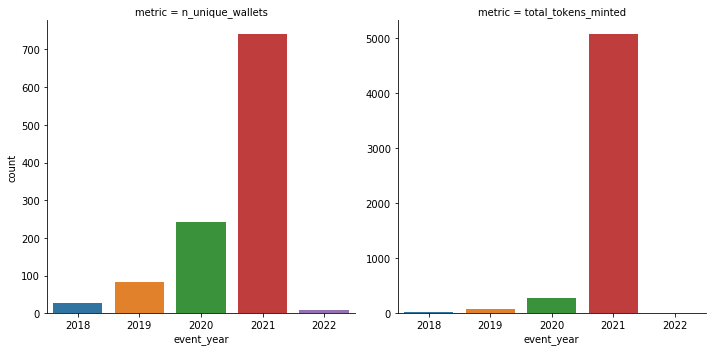

In [182]:
mints = poap.loc[(poap.has_ETH_Denver_POAP==True) & (poap.is_ETHDenver_event==True)]

mints_year = mints.groupby('event_year').agg(n_unique_wallets=('owner_id', 'nunique'), 
                                             total_tokens_minted=('token_id', 'nunique')).reset_index()

mints_melt = pd.melt(mints_year, id_vars=['event_year'], value_vars=['n_unique_wallets', 'total_tokens_minted'], 
                                                         var_name='metric', value_name='count')

print('##### Table #### \n')
print(mints_year)
print('\n')
print('################ \n\n')

print('Number of unique minter addresses per year & total numbers of tokens minted (for ALL ETH Denver related POAPs)')
sns.catplot(data=mints_melt, x='event_year', y='count', col='metric', kind='bar', sharey=False)

plt.show()

**Comment**: The numbers of unique minter addresses in consistently increasing, and it seems 2021 was a huge leap. This is also reflected in the total amount of tokens minted, where this effect in even drastic.

### Rentention (by the lens of POAP minting)

In [183]:
# count of users with X amount of years
lominters = mints.groupby('owner_id').agg(n_years_minted=('event_year', 'nunique')).reset_index()
lominters_group = lominters.groupby('n_years_minted').agg(unique_wallet_count=('owner_id', 'nunique'))
lominters_group['%'] = (lominters_group['unique_wallet_count'] / lominters_group['unique_wallet_count'].sum()) * 100

lominters_group

,unique_wallet_count,%
n_years_minted,,
1,985,94.711538
2,49,4.711538
3,4,0.384615
4,2,0.192308


**Comment:** Kind of makes sense once most people started gong on 2021. What about this % but considering when people started? 

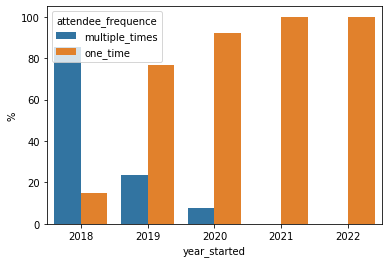

In [184]:
# count of users with X amount of years
lominters = mints.groupby(['owner_id']).agg(n_years_minted=('event_year', 'nunique'), 
                                            year_started=('event_year', 'min')).reset_index()
lominters['attendee_frequence'] = np.where(lominters['n_years_minted']>1, 'multiple_times', 'one_time')
lominters_group = lominters.groupby(['year_started','attendee_frequence']).agg(unique_wallet_count=('owner_id', 'nunique'))
lominters_group['%'] = (lominters_group['unique_wallet_count'] / lominters_group.groupby(level=0).transform('sum')['unique_wallet_count']) * 100

sns.barplot(data=lominters_group.reset_index(), x='year_started', y='%', hue='attendee_frequence')


**Comment**: We could say that the turnover rate here (% of people that just go to the event one time) seems to be increasing over time. This could be very much related to the increasing number of people coming to these events as the years pass by. Because there are relativelt few years of event yet, it remaisn to be seen how the newer cohorts of entrants will stick to the event. 

Limitations of this specific table: 
- As the number of attendes increase, we can have more one-time enthusiats that are only going due to crypto price action / curiosity.
- A LOT of attendees might not redeem their POAPs at all or maybe redeem POAPs in different wallets, which might led to this number increasing.
- As we get closer to recent years, the fewer chances "newer" people have to attend to new events (so with time retention might go up for recent years with time)

## - Event participation profile (ETH Denver attendees)

In [185]:
# here I am using POAP minting + spork token holding to mark people as ETH Denver participant
etha = poap.loc[(poap.is_ETH_Denver_participant==True) & (poap.is_ETHDenver_event==False)].copy()

### Aside from ETH Denver, what other types of events are these people going?

#### - Virtual vs IRL

In [186]:
virl = etha.groupby('virtual_event').agg(number_of_events=('event_name', 'nunique'))
virl['%'] = (virl['number_of_events'] / virl['number_of_events'].sum()) * 100
virl

,number_of_events,%
virtual_event,,
False,1859,20.810478
True,7074,79.189522


**Comment**:Most of the events attended by this people are online.

#### - Ethereum vs Non Ethereum events

In [187]:
virl = etha.groupby('is_ethereum_related_event').agg(number_of_events=('event_name', 'nunique'))
virl['%'] = (virl['number_of_events'] / virl['number_of_events'].sum()) * 100
virl

,number_of_events,%
is_ethereum_related_event,,
False,8385,93.875952
True,547,6.124048


**Comment**: A lot of these events are not ethereum related too (although is hard to assess just from the name of the event so.. might be far from accurate here)

#### - Event country

In [188]:
virl = etha.groupby('event_country').agg(number_of_events=('event_name', 'nunique'))
virl['%'] = (virl['number_of_events'] / virl['number_of_events'].sum()) * 100
virl.sort_values('%', ascending=False).head(10)

,number_of_events,%
event_country,,
,6680,74.787282
United States,472,5.284371
Decentraland,306,3.425884
USA,178,1.992835
Argentina,126,1.410658
Decentraland [27 | -118],71,0.794895
AMA Stage,69,0.772503
United Kingdom,68,0.761308
Metaverse,63,0.705329


**Comment**: Hard to assess too once the names of the countries don't have a standard and also big part of the entries don't have this field filled. 

#### - Most popular events among participants

In [189]:
#filtering out ETH Denver
evrank = etha.groupby(['event_name', 'is_ethereum_related_event'])\
                .agg(attendee_count=('owner_id', 'nunique'))\
                .sort_values('attendee_count', ascending=False)
evrank['%_total_participants'] = (evrank['attendee_count'] / len(poap.loc[poap.is_ETH_Denver_participant==True, 'owner_id'].unique()))

evrank.head(10)

,,attendee_count,%_total_participants
event_name,is_ethereum_related_event,,
The One Millionth POAP POAP,False,180,0.089641
The Graph - Subgraph developer,False,177,0.088147
Bankless Member - 2021,False,160,0.079681
Ethereum London Network Upgrade,True,128,0.063745
Arbitrum Launch,False,116,0.057769
EthStaker Presents: London Network Upgrade Livestream Party,True,115,0.057271
Devcon5,False,100,0.049801
ConstitutionDAO Contributor,False,98,0.048805
Early Issuers,False,91,0.045319


**Comment**: It seems from the names that the most popuplar events are either builder-type events or ethereum related.

### Does a ETH Denver partipant attend to more events than a non participant does? 

In [190]:
evcs = poap.groupby(['owner_id', 'is_ETH_Denver_participant']).agg(event_count=('event_name', 'nunique')).reset_index()
avgs = evcs.groupby('is_ETH_Denver_participant').agg(avg_number_events_attended=('event_count', 'mean')).reset_index()

avgs

,is_ETH_Denver_participant,avg_number_events_attended
0,False,5.251601
1,True,36.368526


In [191]:
participants_count = evcs.loc[evcs.is_ETH_Denver_participant==True, 'event_count']
non_participants_count = evcs.loc[evcs.is_ETH_Denver_participant==False, 'event_count']

t_test, p_value = stats.ttest_ind(participants_count, non_participants_count, equal_var=False)

attendee_avg = avgs.loc[avgs.is_ETH_Denver_participant==True, 'avg_number_events_attended'].values[0]
non_attendee_avg = avgs.loc[avgs.is_ETH_Denver_participant==False, 'avg_number_events_attended'].values[0]
avg_diff = attendee_avg / non_attendee_avg

print(f"The average number of events attended by an ETH Denver participants is {avg_diff:2f}x higher than non-participants. ")
print(f"T-test has good confidence with a p-value of: {p_value}")

The average number of events attended by an ETH Denver participants is 6.925227x higher than non-participants. 
T-test has good confidence with a p-value of: 1.509988353079819e-11


### After attending to their first ETH Denver, do participants participate in more events? 

In [192]:
first_ethd = poap.loc[poap.is_ETHDenver_event==True].groupby('owner_id').agg(first_attendance_date=('event_start_date', 'min')).reset_index()
etha = etha.merge(first_ethd, on='owner_id', how='left')

etha['event_after_first_attendance_ethdenver'] = np.where(etha.event_start_date>etha.first_attendance_date, True, False)
edev = etha.groupby(['owner_id', 'event_after_first_attendance_ethdenver']).agg(event_count=('event_name', 'nunique')).reset_index()

ev_avg = edev.groupby('event_after_first_attendance_ethdenver').agg(avg_events_attended=('event_count', 'mean')).reset_index()
ev_avg

,event_after_first_attendance_ethdenver,avg_events_attended
0,False,32.140461
1,True,38.911712


In [193]:
before_ethd = edev.loc[edev.event_after_first_attendance_ethdenver==True, 'event_count']
after_ethd = edev.loc[edev.event_after_first_attendance_ethdenver==False, 'event_count']

t_test_2, p_value_2 = stats.ttest_ind(before_ethd, after_ethd, equal_var=False)

before_avg = ev_avg.loc[ev_avg.event_after_first_attendance_ethdenver==True, 'avg_events_attended'].values[0]
after_avg = ev_avg.loc[ev_avg.event_after_first_attendance_ethdenver==False, 'avg_events_attended'].values[0]
avg_diff = after_avg / before_avg


print(f"The average number of events attended after first participation in ETH Denver is {(avg_diff * 100):.1f}% higher than before attending. ")
print(f"T-test has good confidence with a p-value of: {p_value_2:.4f}")

The average number of events attended after first participation in ETH Denver is 82.6% higher than before attending. 
T-test has good confidence with a p-value of: 0.3359


## - Activity in the DAO space

In [194]:
####  CREATING the lead dataframe to check DAOmembership  ####

## here I am using Snapshot votes, proposals and profile creation data do I can get a indirect measures of membership of a DAO

# DaoHaus

dhmembers = dh_members.groupby(['address_normalized', 'dao_name']).agg(count=('address_normalized', 'count')).reset_index()
dhmembers = dhmembers.rename(columns={'address_normalized':'address'})
dhmembers['type'] = 'daohaus_members'

#Snapshot

sprops = snap_proposals.groupby(['author', 'space_name']).agg(count=('id', 'nunique')).reset_index()
sprops = sprops.rename(columns={'author': 'address'})
sprops['type'] = 'snapshot_proposal_creation'

svotes = snap_votes.groupby(['voter', 'space_name']).agg(count=('proposal_id', 'nunique')).reset_index()
svotes = svotes.rename(columns={'voter': 'address'})
svotes['type'] = 'snapshot_votes'

screation = snap_creation.groupby(['member_address', 'space_name']).agg(count=('space_id', 'count')).reset_index()
screation = screation.rename(columns={'member_address': 'address'})
screation['type'] = 'snapshot_creation'

snap_activity = pd.concat([sprops, svotes, screation])
snap_activity = snap_activity.rename(columns={'space_name':'dao_name'})

#creating a big merge of the two dfs

daomembers = pd.concat([snap_activity, dhmembers])

daomembers.head()

,address,dao_name,count,type
0,0x000000000057E8ABd581828A2b40076852C0bA6E,Indexed Finance,27,snapshot_proposal_creation
1,0x0000000000B896235CC0c9513670975c0512b0C8,Gummy,2,snapshot_proposal_creation
2,0x0000000000e189dD664b9aB08a33C4839953852c,Curve Finance,7,snapshot_proposal_creation
3,0x000000003f18B190E18246807295d001921C3ca4,moonrat.finance,1,snapshot_proposal_creation
4,0x00000098e8b8cB65aC3E25Dc462368b00E790176,PancakeSwap,3,snapshot_proposal_creation


### The DAOs ETH Denver attendees participate

In [195]:
#getting unique values for wallet : DAO_name - once there might be duplicate using directly daomemberes
daomem_clean = daomembers.groupby(['address', 'dao_name']).agg(count=('dao_name', 'nunique')).sort_values('count', ascending=False).reset_index()

ethd = ethd.merge(daomem_clean.loc[:, ['address', 'dao_name']], on='address', how='left')
ethd['participate_in_DAO'] = False
ethd.loc[ethd.dao_name.notnull(), 'participate_in_DAO'] = True

#### % of participants in DAOs

In [196]:
partd = ethd.groupby('participate_in_DAO').agg(wallet_count=('address', 'nunique')).reset_index()
partd['%'] = (partd['wallet_count'] / partd['wallet_count'].sum()) * 100
partd

,participate_in_DAO,wallet_count,%
0,False,1994,53.891892
1,True,1706,46.108108


#### Most popular DAOs

In [197]:
popd = ethd.loc[ethd.participate_in_DAO==True]\
    .groupby('dao_name')\
    .agg(wallet_count=('address', 'nunique'))\
    .sort_values('wallet_count', ascending=False)\
    .reset_index()

popd['%_total_accounts'] = (popd['wallet_count'] / len(ethd.address.unique())) * 100
popd.head(15)

,dao_name,wallet_count,%_total_accounts
0,ENS,1174,31.729730
1,Bankless DAO,120,3.243243
2,Gitcoin,111,3.000000
3,BadgerDAO,98,2.648649
4,ChessDAO,79,2.135135
5,Sushi,70,1.891892
6,Aavegotchi,69,1.864865
7,Friends With Benefits Pro,66,1.783784
8,Rarible Protocol DAO,56,1.513514
9,PancakeSwap,55,1.486486


#### Are ETH participants participating in more DAOs than an average member? 

In [198]:
#comparing ETH Denver participants that participate in at least 1 DAO vs the dao members df created - that only includes people in at least 1 DAO too

ethdenver_n_daos =  ethd.loc[ethd.participate_in_DAO==True].groupby('address').agg(dao_count=('dao_name', 'nunique')).reset_index()
nondenver_n_daos = daomembers.groupby('address').agg(dao_count=('dao_name', 'nunique')).reset_index()
ethdenver_avg_daos = ethdenver_n_daos.dao_count.sum() / len(ethdenver_n_daos.address.unique())

perc_below_alpha, final_mean = calculate_multisample_t_test(nondenver_n_daos['dao_count'], ethdenver_n_daos['dao_count'])

print('## Avereage number of DAOs active ## \n\n')
print(f"ETH Denver participants: {ethdenver_avg_daos} \nAverage DAO members (not necessarily ETH Denver participate: {final_mean} \n")


print(f'After running multiple t-tests in multiple sub samples the values were below alpha of 5% in {perc_below_alpha:.2f}% of times.')

## Avereage number of DAOs active ## 


ETH Denver participants: 3.1400937866354046 
Average DAO members (not necessarily ETH Denver participate: 1.7126088573919758 

After running multiple t-tests in multiple sub samples the values were below alpha of 5% in 100.00% of times.


### How active these addresses are compared to the average DAO member ?

In [199]:
#getting DaoHaus votes and proposals

#proposals
dhprops = dh_proposals.groupby(['applicant_normalized', 'dao_name']).agg(count=('proposal_id', 'nunique')).reset_index()
dhprops = dhprops.rename(columns={'applicant_normalized': 'address'})
dhprops['type'] = 'daohaus_proposals'

#votes
dhvotes = dh_votes.groupby(['address_normalized', 'dao_name']).agg(count=('id', 'nunique')).reset_index()
dhvotes = dhvotes.rename(columns={'address_normalized':'address'})
dhvotes['type'] = 'daohaus_votes'

daoactivity = pd.concat([daomembers, dhprops, dhvotes])

daoactivity.head(3)

,address,dao_name,count,type
0,0x000000000057E8ABd581828A2b40076852C0bA6E,Indexed Finance,27,snapshot_proposal_creation
1,0x0000000000B896235CC0c9513670975c0512b0C8,Gummy,2,snapshot_proposal_creation
2,0x0000000000e189dD664b9aB08a33C4839953852c,Curve Finance,7,snapshot_proposal_creation


#### On proposal creation

% with proposal created

In [205]:
total_props = daoactivity.loc[daoactivity.type.isin(['snapshot_proposal_creation', 'daohaus_proposals'])]\
                         .groupby('address').agg(total_props=('count', 'sum'))\
                         .reset_index()

ethd_prop = ethd.loc[ethd.participate_in_DAO==True].merge(total_props, on='address', how='left').drop_duplicates('address')  #not merging by dao_name so need to exclude duplicates
ethd_prop['total_props'] = ethd_prop['total_props'].fillna(0)
ethd_prop['has_proposal'] = np.where(ethd_prop['total_props']>0, True, False)

properc = ethd_prop.groupby('has_proposal').agg(wallet_count=('address', 'nunique')).reset_index()
properc['%'] = (properc['wallet_count'] / properc['wallet_count'].sum()) * 100

properc

,has_proposal,wallet_count,%
0,False,1490,87.338804
1,True,216,12.661196


Do ETH participants create more proposals than the average DAO member?

In [201]:
denver_avg_proposals = ethd_prop.loc[ethd_prop.participate_in_DAO==True]

avg_denver_proposals = denver_avg_proposals['total_props'].sum() / len(denver_avg_proposals.address.unique())
avg_nondenver_proposals = total_props['total_props'].sum() / len(total_props.address.unique())

perc_below_alpha, final_mean = calculate_multisample_t_test(total_props['total_props'], denver_avg_proposals['total_props'])

print('## Average number of proposals created ## \n\n')
print(f"ETH Denver participants: {avg_denver_proposals} \nAverage DAO members (not necessarily ETH Denver participant): {final_mean} \n")


print(f'After running multiple t-tests in multiple sub samples the values were below alpha of 5% in {perc_below_alpha:.2f}% of times.')

## Average number of proposals created ## 


ETH Denver participants: 0.5644783118405627 
Average DAO members (not necessarily ETH Denver participant): 2.2027660720509488 

After running multiple t-tests in multiple sub samples the values were below alpha of 5% in 100.00% of times.


#### On votes

% with votes

In [206]:
total_votes = daoactivity.loc[daoactivity.type.isin(['snapshot_votes', 'daohaus_votes'])]\
                         .groupby('address').agg(total_votes=('count', 'sum'))\
                         .reset_index()

ethd_votes = ethd.loc[ethd.participate_in_DAO==True].merge(total_votes, on='address', how='left').drop_duplicates('address')
ethd_votes['total_props'] = ethd_votes['total_votes'].fillna(0)
ethd_votes['has_votes'] = np.where(ethd_votes['total_votes']>0, True, False)

provet = ethd_votes.groupby('has_votes').agg(wallet_count=('address', 'nunique')).reset_index()
provet['%'] = (provet['wallet_count'] / provet['wallet_count'].sum()) * 100

provet

,has_votes,wallet_count,%
0,False,65,3.810082
1,True,1641,96.189918


Do ETH participants create more proposals than the average DAO member?

In [203]:
denver_avg_votes = ethd_votes.loc[ethd_votes.participate_in_DAO==True]

avg_denver_votes = denver_avg_votes['total_votes'].sum() / len(denver_avg_votes.address.unique())
avg_nondenver_votes = total_votes['total_votes'].sum() / len(total_votes.address.unique())

erc_below_alpha, final_mean = calculate_multisample_t_test(total_votes['total_votes'], denver_avg_votes['total_votes'])

print('## Average number of proposals created ## \n\n')
print(f"ETH Denver participants: {avg_denver_votes} \nAverage DAO members (not necessarily ETH Denver participate: {final_mean} \n")


print(f'After running multiple t-tests in multiple sub samples the values were below alpha of 5% in {perc_below_alpha:.2f}% of times.')

## Average number of proposals created ## 


ETH Denver participants: 9.678780773739742 
Average DAO members (not necessarily ETH Denver participate: 4.992958374552748 

After running multiple t-tests in multiple sub samples the values were below alpha of 5% in 100.00% of times.


## - Token bags

Check why number of proposals are coming all the same for all DAOs

In [204]:
denver_avg_proposals.sort_values('address').head(10)

,address,has_ETH_Denver_POAP,spork_balance,spork_normalized_balance,bufficorn_token_id,profile_type,dao_name,participate_in_DAO,total_props,has_proposal
1427,0x00000000005dbcB0d0513FcDa746382Fe8a53468,True,3.283922e+22,32839.221567,1932.0,poap_spork_and_bufficorn_holder,MetaFactory,True,0.0,False
5979,0x0039F22efB07A647557C7C5d17854CFD6D489eF3,NaN,4.676353e+21,4676.353110,NaN,spork_holder_only,ENS,True,1.0,True
2105,0x0040DAAC32D83c78546ae36dA42A496B28ab09E1,NaN,3.902079e+21,3902.078710,1990.0,spork_and_bufficorn_holder,PancakeSwap,True,0.0,False
4586,0x0042000F3DDe458BC95880565aD5A4981FF1122E,NaN,3.512000e+22,35120.000000,1591.0,spork_and_bufficorn_holder,ENS,True,0.0,False
1106,0x0067eEC7AD35e72613d760E917890D1B7E876e4E,True,1.902079e+21,1902.078710,NaN,poap_and_spork_holder,ENS,True,0.0,False
742,0x00A839dE7922491683f547a67795204763ff8237,True,NaN,NaN,NaN,poap_holder_only,ENS,True,0.0,False
5988,0x00De4B13153673BCAE2616b67bf822500d325Fc3,NaN,4.440920e+23,444092.030000,NaN,spork_holder_only,ENS,True,1.0,True
5218,0x00aF41c6EE0B153E973004529db12e35A65748f6,NaN,1.000000e+13,0.000010,3262.0,spork_and_bufficorn_holder,CityDAO,True,0.0,False
3331,0x00f16DdF3034436fC981194A0192044ce90Aa4C1,NaN,1.902079e+21,1902.078710,NaN,spork_holder_only,Gitcoin,True,0.0,False
7107,0x010462E09d11875B5b17e1d800951919423F9616,NaN,NaN,NaN,3930.0,bufficorn_holder_only,ENS,True,0.0,False
